# Figure S4 - CoMight simulation



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics

# import math
# import scipy
from sklearn.metrics import roc_auc_score

# plot joint distribution of x in 2D with joint and marginal histograms

# from treeple.datasets import make_trunk_classification, make_trunk_mixture_classification


def _moving_avg_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    cov_matrix = rho ** np.abs(i - j)

    # Apply the banding condition
    cov_matrix[abs(i - j) > 1] = 0
    return cov_matrix

In [4]:
import matplotlib.gridspec as gridspec


class SeabornFig2Grid:
    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or isinstance(
            self.sg, sns.axisgrid.PairGrid
        ):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """Move PairGrid or Facetgrid"""
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n, m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """Move Jointgrid"""
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(
            r + 1, r + 1, subplot_spec=self.subplot
        )

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        # https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [5]:
def generate_mean_shift(mu0, mu1, sig0, sig1, n=10000, prior=[0.5, 0.5], mix=None):
    p = sig0.shape[0]
    p_class0, p_class1 = prior
    pdf_class0 = multivariate_normal(mean=mu0, cov=sig0, allow_singular=True)
    pdf_class1 = multivariate_normal(mean=mu1, cov=sig1, allow_singular=True)

    x_0 = pdf_class0.rvs(size=n).reshape((n, p))
    x_1 = pdf_class1.rvs(size=n).reshape((n, p))
    x = np.vstack((x_0, x_1))
    y = [0] * n + [1] * n

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1 = np.nan_to_num(pdf_class1.pdf(x))

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1

    pos_class0 = np.array(
        [
            p_x_given_class0[i] * p_class0 / p_x[i] if p_x[i] != 0 else 0
            for i in range(p_x.shape[0])
        ]
    ).reshape(-1, 1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0
    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))

    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0, p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    MI = entropy_y - stats_conen
    # calculate conditional mutual information
    # I(X; Y | Z) = H(X | Z) - H(X | Y, Z)

    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )
    s98 = np.max(tpr[fpr <= 0.02])

    AUC = roc_auc_score(y, posterior[:, 1])

    accuracy = np.mean(np.array(y) == np.argmax(posterior, axis=1))

    # create a dataframe with the data
    if p == 2:
        df = pd.DataFrame(x, columns=["view1", "view2"])
    else:
        df = pd.DataFrame(x)
    df["y"] = y
    # if p == 1:
    #     x_range = np.linspace(np.min(x), np.max(x), n)
    #     pdf0 = pdf_class0.pdf(x_range)
    #     pdf1 = pdf_class1.pdf(x_range)
    # else:
    #     x_range = np.linspace(np.min(x[:,0]), np.max(x[:,0]), n)
    #     y_range = np.linspace(np.min(x[:,1]), np.max(x[:,1]), n)
    #     xx, yy = np.meshgrid(x_range, y_range)
    #     xy_range = np.vstack((xx.flatten(), yy.flatten())).T
    #     pdf0 = pdf_class0.pdf(xy_range).reshape(n, n)
    #     pdf1 = pdf_class1.pdf(xy_range).reshape(n, n)

    results = {
        "df": df,
        # "val_range": x_range if p==1 else xy_range,
        # "pdf0": pdf0,
        # "pdf1": pdf1,
        "posterior": posterior,
        "MI": MI,
        "ACC": accuracy,
        "s98": s98,
        "AUC": AUC,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    }
    return results

In [6]:
def generate_multi_modal(
    mu0, mu1, sig0, sig1, p0=[0.75, 0.25], p1=[0.75, 0.25], n=100000, prior=[0.5, 0.5]
):
    # create an indicator for multi-equal simulation
    if (
        np.array_equal(mu0, mu1)
        and np.array_equal(sig0, sig1)
        and np.array_equal(p0, p1)
    ):
        multi_equal = True
    else:
        multi_equal = False

    p = sig0[0].shape[0]
    p_class0, p_class1 = prior
    # print(mu0,mu1)
    pdf_class0_1 = multivariate_normal(mean=mu0[0], cov=sig0[0], allow_singular=True)
    pdf_class0_2 = multivariate_normal(mean=mu0[1], cov=sig0[1], allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean=mu1[0], cov=sig1[0], allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean=mu1[1], cov=sig1[1], allow_singular=True)

    # print(pdf_class0_1.rvs(size = int(n*p0[0])).shape)
    x_0_1 = pdf_class0_1.rvs(size=int(n * p0[0])).reshape((int(n * p0[0]), p))
    x_0_2 = pdf_class0_2.rvs(size=int(n * p0[1])).reshape((int(n * p0[1]), p))
    x_1_1 = pdf_class1_1.rvs(size=int(n * p1[0])).reshape((int(n * p1[0]), p))
    x_1_2 = pdf_class1_2.rvs(size=int(n * p1[1])).reshape((int(n * p1[1]), p))

    # print(x_1_1)
    x_0 = np.vstack([x_0_1, x_0_2])
    x_1 = np.vstack([x_1_1, x_1_2])
    x = np.vstack((x_0_1, x_0_2, x_1_1, x_1_2))
    y = [0] * x_0.shape[0] + [1] * x_1.shape[0]
    # create a dataframe with the data
    if p == 2:
        df = pd.DataFrame(x, columns=["view1", "view2"])
    else:
        df = pd.DataFrame(x)
    df["y"] = y

    p_x_given_class0_1 = np.nan_to_num(pdf_class0_1.pdf(x))
    p_x_given_class0_2 = np.nan_to_num(pdf_class0_2.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(x))

    p_x_given_class0 = p0[0] * p_x_given_class0_1 + p0[1] * p_x_given_class0_2
    p_x_given_class1 = p1[0] * p_x_given_class1_1 + p1[1] * p_x_given_class1_2

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1
    # pos_class0 = p_x_given_class0*p_class0/p_x

    pos_class0 = np.array(
        [
            p_x_given_class0[i] * p_class0 / p_x[i] if p_x[i] != 0 else 0
            for i in range(p_x.shape[0])
        ]
    ).reshape(-1, 1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0
    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))

    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0, p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen

    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )

    if multi_equal or MI == 0.0:
        # replace the posterior with random numbers ~ U(0,1) to calculate the ROC curve
        posterior_ = np.random.uniform(0, 1, size=(df.shape[0], 2))
        fpr, tpr, thresholds = metrics.roc_curve(
            y, posterior_[:, 1], pos_label=1, drop_intermediate=False
        )

    s98 = np.max(tpr[fpr <= 0.02])

    AUC = roc_auc_score(y, posterior[:, 1])

    accuracy = np.mean(np.array(y) == np.argmax(posterior, axis=1))

    # if p==1:
    #     x_range = np.linspace(x.min(), x.max(), n)
    #     p_x_given_class0_1 = np.nan_to_num(pdf_class0_1.pdf(x_range))
    #     p_x_given_class0_2 = np.nan_to_num(pdf_class0_2.pdf(x_range))
    #     p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(x_range))
    #     p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(x_range))

    # else:
    #     x_range = np.linspace(x[:,0].min(), x[:,0].max(), n)
    #     y_range = np.linspace(x[:,1].min(), x[:,1].max(), n)
    #     xx, yy = np.meshgrid(x_range, y_range)
    #     xy_range = np.vstack((xx.flatten(), yy.flatten())).T
    #     p_x_given_class0_1 = np.nan_to_num(pdf_class0_1.pdf(xy_range))
    #     p_x_given_class0_2 = np.nan_to_num(pdf_class0_2.pdf(xy_range))
    #     p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(xy_range))
    #     p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(xy_range))

    # pdf0 = p0[0] * p_x_given_class0_1 + p0[1] * p_x_given_class0_2
    # pdf1 = p1[0] * p_x_given_class1_1 + p1[1] * p_x_given_class1_2

    results = {
        "df": df,
        # "val_range": x_range if p==1 else xy_range,
        # "pdf0": pdf0,
        # "pdf1": pdf1,
        "posterior": posterior,
        "ACC": accuracy,
        "MI": MI,
        "s98": s98,
        "AUC": AUC,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    }

    return results

In [7]:
n = 1000000
p = 2
mu = 1
rho = 0.5
mu0 = np.zeros(p)
mu1 = np.array([1, 0]) * mu
sig = np.identity(1)
sig0 = _moving_avg_cov(p, 0)
sig1 = _moving_avg_cov(p, rho)
# val_range = np.linspace(-5, 5, n)
bins = 50

# generate data
results = generate_mean_shift(mu0, mu1, sig0, sig1, n=n)
df = results["df"]
df.columns = ["view1", "view2", "y"]
# generate results for view 1
results_v1 = generate_mean_shift(mu0[0], mu1[0], sig, sig, n=n)
df_v1 = results_v1["df"]
# generate results for view 2
results_v2 = generate_mean_shift(mu0[1], mu1[1], sig, sig, n=n)
df_v2 = results_v2["df"]

df_roc = pd.DataFrame(
    {"fpr": results["fpr"], "tpr": results["tpr"], "thresholds": results["thresholds"]}
)
df_roc_v1 = pd.DataFrame(
    {
        "fpr": results_v1["fpr"],
        "tpr": results_v1["tpr"],
        "thresholds": results_v1["thresholds"],
    }
)
df_roc_v2 = pd.DataFrame(
    {
        "fpr": results_v2["fpr"],
        "tpr": results_v2["tpr"],
        "thresholds": results_v2["thresholds"],
    }
)
# marge the df_roc, df_roc_v1, df_roc_v2
df_roc_all = pd.concat([df_roc, df_roc_v1, df_roc_v2], axis=0)
# add a column to the df_roc_all denoting the view
df_roc_all["view"] = (
    ["joint"] * len(df_roc) + ["view1"] * len(df_roc_v1) + ["view2"] * len(df_roc_v2)
)

CMI_v1 = results["MI"] - (results_v2["MI"])
CMI_v2 = results["MI"] - (results_v1["MI"])

joint_stats = {
    "MI": results["MI"],
    "CMI": "None",
    "s98": results["s98"],
    "AUC": results["AUC"],
    "ACC": results["ACC"],
}
view1_stats = {
    "MI": results_v1["MI"],
    "CMI": CMI_v1,
    "s98": results_v1["s98"],
    "AUC": results_v1["AUC"],
    "ACC": results_v1["ACC"],
}
view2_stats = {
    "MI": results_v2["MI"],
    "CMI": CMI_v2,
    "s98": results_v2["s98"],
    "AUC": results_v2["AUC"],
    "ACC": results_v2["ACC"],
}

# convert the results to a dataframe
df_stats = pd.DataFrame([joint_stats, view1_stats, view2_stats])
df_stats.index = ["joint", "view1", "view2"]
display(df_stats)

# save the data as an array
mean_shift_data = [df, df_v1, df_v2, df_roc, df_roc_v1, df_roc_v2, df_stats]

# mean_shift_plot_range = [results['val_range'], results_v1['val_range'], results_v2['val_range']]
# mean_shift_plot_pdf0 = [results['pdf0'], results_v1['pdf0'], results_v2['pdf0']]
# mean_shift_plot_pdf1 = [results['pdf1'], results_v1['pdf1'], results_v2['pdf1']]

,MI,CMI,s98,AUC,ACC
joint,1.428125e-01,None,0.176857,0.784171,0.702705
view1,1.113287e-01,0.142813,0.147699,0.760967,0.691955
view2,-1.332268e-15,0.031484,0.000000,0.500000,0.500000


In [8]:
# n = 10000
rho = 0.5
rho_diag = 1
mu_0 = np.array([[0, 0], [5, 1]])
mu_1 = np.array([[0, 0], [5, 1]])
sig0 = _moving_avg_cov(2, rho)
sig1 = _moving_avg_cov(2, rho)
p0 = [0.75, 0.25]
p1 = [0.75, 0.25]
sig_0 = [sig0, sig0]
sig_1 = [sig1, sig1]

multi_equal_results_joint = generate_multi_modal(mu_0, mu_1, sig_0, sig_1, p0, p1, n=n)
multi_equal_results_v1 = generate_multi_modal(
    mu_0[:, 0],
    mu_1[:, 0],
    [np.identity(1), np.identity(1)],
    [rho_diag * np.identity(1), rho_diag * np.identity(1)],
    p0,
    p1,
    n=n,
)
multi_equal_results_v2 = generate_multi_modal(
    mu_0[:, 1],
    mu_1[:, 1],
    [np.identity(1), np.identity(1)],
    [rho_diag * np.identity(1), rho_diag * np.identity(1)],
    p0,
    p1,
    n=n,
)

# create a dataframe with the results
multi_equal_df = multi_equal_results_joint["df"]
multi_equal_df_v1 = multi_equal_results_v1["df"]
multi_equal_df_v2 = multi_equal_results_v2["df"]

multi_equal_df_roc = pd.DataFrame(
    {
        "fpr": multi_equal_results_joint["fpr"],
        "tpr": multi_equal_results_joint["tpr"],
        "thresholds": multi_equal_results_joint["thresholds"],
    }
)
multi_equal_df_roc_v1 = pd.DataFrame(
    {
        "fpr": multi_equal_results_v1["fpr"],
        "tpr": multi_equal_results_v1["tpr"],
        "thresholds": multi_equal_results_v1["thresholds"],
    }
)
multi_equal_df_roc_v2 = pd.DataFrame(
    {
        "fpr": multi_equal_results_v2["fpr"],
        "tpr": multi_equal_results_v2["tpr"],
        "thresholds": multi_equal_results_v2["thresholds"],
    }
)

CMI_v1 = multi_equal_results_joint["MI"] - (multi_equal_results_v2["MI"])
CMI_v2 = multi_equal_results_joint["MI"] - (multi_equal_results_v1["MI"])

multi_equal_joint_stats = {
    "MI": multi_equal_results_joint["MI"],
    "CMI": "None",
    "s98": multi_equal_results_joint["s98"],
    "AUC": multi_equal_results_joint["AUC"],
    "ACC": multi_equal_results_joint["ACC"],
}
multi_equal_view1_stats = {
    "MI": multi_equal_results_v1["MI"],
    "CMI": CMI_v1,
    "s98": multi_equal_results_v1["s98"],
    "AUC": multi_equal_results_v1["AUC"],
    "ACC": multi_equal_results_v1["ACC"],
}
multi_equal_view2_stats = {
    "MI": multi_equal_results_v2["MI"],
    "CMI": CMI_v2,
    "s98": multi_equal_results_v2["s98"],
    "AUC": multi_equal_results_v2["AUC"],
    "ACC": multi_equal_results_v2["ACC"],
}

# convert the results to a dataframe
multi_equal_df_stats = pd.DataFrame(
    [multi_equal_joint_stats, multi_equal_view1_stats, multi_equal_view2_stats]
)
multi_equal_df_stats.index = ["joint", "view1", "view2"]
display(multi_equal_df_stats.round(2))

# save the data as an array
multi_equal_data = [
    multi_equal_df,
    multi_equal_df_v1,
    multi_equal_df_v2,
    multi_equal_df_roc,
    multi_equal_df_roc_v1,
    multi_equal_df_roc_v2,
    multi_equal_df_stats,
]

# multi_equal_plot_range = [multi_equal_results_joint['val_range'], multi_equal_results_v1['val_range'], multi_equal_results_v2['val_range']]
# multi_equal_plot_pdf0 = [multi_equal_results_joint['pdf0'], multi_equal_results_v1['pdf0'], multi_equal_results_v2['pdf0']]
# multi_equal_plot_pdf1 = [multi_equal_results_joint['pdf1'], multi_equal_results_v1['pdf1'], multi_equal_results_v2['pdf1']]

,MI,CMI,s98,AUC,ACC
joint,-0.0,None,0.02,0.5,0.5
view1,-0.0,0.0,0.02,0.5,0.5
view2,-0.0,0.0,0.02,0.5,0.5


In [9]:
# n = 10000
rho = 0.2
rho_diag = 1
mu_0 = np.array([[0, 0], [0, 0]])
mu_1 = np.array([[0, 0], [5, 1]])
sig0 = _moving_avg_cov(2, 0)
sig1 = _moving_avg_cov(2, rho)
p0 = [0.75, 0.25]
p1 = [0.75, 0.25]
sig_0 = [sig0, sig0]
sig_1 = [sig1, sig1]

multi_mod_results_joint = generate_multi_modal(mu_0, mu_1, sig_0, sig_1, p0, p1, n=n)
multi_mod_results_v1 = generate_multi_modal(
    mu_0[:, 0],
    mu_1[:, 0],
    [np.identity(1), np.identity(1)],
    [rho_diag * np.identity(1), rho_diag * np.identity(1)],
    p0,
    p1,
    n=n * 2,
)
multi_mod_results_v2 = generate_multi_modal(
    mu_0[:, 1],
    mu_1[:, 1],
    [np.identity(1), np.identity(1)],
    [rho_diag * np.identity(1), rho_diag * np.identity(1)],
    p0,
    p1,
    n=n * 2,
)

# create a dataframe with the results
multi_mod_df = multi_mod_results_joint["df"]
multi_mod_df_v1 = multi_mod_results_v1["df"]
multi_mod_df_v2 = multi_mod_results_v2["df"]

multi_mod_df_roc = pd.DataFrame(
    {
        "fpr": multi_mod_results_joint["fpr"],
        "tpr": multi_mod_results_joint["tpr"],
        "thresholds": multi_mod_results_joint["thresholds"],
    }
)
multi_mod_df_roc_v1 = pd.DataFrame(
    {
        "fpr": multi_mod_results_v1["fpr"],
        "tpr": multi_mod_results_v1["tpr"],
        "thresholds": multi_mod_results_v1["thresholds"],
    }
)
multi_mod_df_roc_v2 = pd.DataFrame(
    {
        "fpr": multi_mod_results_v2["fpr"],
        "tpr": multi_mod_results_v2["tpr"],
        "thresholds": multi_mod_results_v2["thresholds"],
    }
)

CMI_v1 = multi_mod_results_joint["MI"] - (multi_mod_results_v2["MI"])
CMI_v2 = multi_mod_results_joint["MI"] - (multi_mod_results_v1["MI"])

multi_mod_joint_stats = {
    "MI": multi_mod_results_joint["MI"],
    "CMI": "None",
    "s98": multi_mod_results_joint["s98"],
    "AUC": multi_mod_results_joint["AUC"],
    "ACC": multi_mod_results_joint["ACC"],
}
multi_mod_view1_stats = {
    "MI": multi_mod_results_v1["MI"],
    "CMI": CMI_v1,
    "s98": multi_mod_results_v1["s98"],
    "AUC": multi_mod_results_v1["AUC"],
    "ACC": multi_mod_results_v1["ACC"],
}
multi_mod_view2_stats = {
    "MI": multi_mod_results_v2["MI"],
    "CMI": CMI_v2,
    "s98": multi_mod_results_v2["s98"],
    "AUC": multi_mod_results_v2["AUC"],
    "ACC": multi_mod_results_v2["ACC"],
}

# convert the results to a dataframe
multi_mod_df_stats = pd.DataFrame(
    [multi_mod_joint_stats, multi_mod_view1_stats, multi_mod_view2_stats]
)
# label the rows as joint, view1, view2
multi_mod_df_stats.index = ["joint", "view1", "view2"]
display(multi_mod_df_stats)

# save the data as an array
multi_mod_data = [
    multi_mod_df,
    multi_mod_df_v1,
    multi_mod_df_v2,
    multi_mod_df_roc,
    multi_mod_df_roc_v1,
    multi_mod_df_roc_v2,
    multi_mod_df_stats,
]

# multi_mod_plot_range = [
#     multi_mod_results_joint["val_range"],
#     multi_mod_results_v1["val_range"],
#     multi_mod_results_v2["val_range"],
# ]
# multi_mod_plot_pdf0 = [
#     multi_mod_results_joint["pdf0"],
#     multi_mod_results_v1["pdf0"],
#     multi_mod_results_v2["pdf0"],
# ]
# multi_mod_plot_pdf1 = [
#     multi_mod_results_joint["pdf1"],
#     multi_mod_results_v1["pdf1"],
#     multi_mod_results_v2["pdf1"],
# ]

,MI,CMI,s98,AUC,ACC
joint,0.096668,None,0.273094,0.661342,0.627552
view1,0.092106,0.087931,0.264485,0.624931,0.623420
view2,0.008737,0.004562,0.051422,0.564944,0.547781


In [10]:
# combine the data
all_data = [mean_shift_data, multi_mod_data, multi_equal_data]

# add a clumn to indicate the label for Control and Case
for i in range(len(all_data)):
    all_data[i][0]["label"] = [
        "Control" if i == 0 else "Case" for i in all_data[i][0]["y"]
    ]

stats_mean_shift, stats_multi_mod, stats_multi_equal = [
    mean_shift_data[-1],
    multi_mod_data[-1],
    multi_equal_data[-1],
]
# concatenate the data and transpose
all_stats = pd.concat([stats_mean_shift, stats_multi_mod, stats_multi_equal], axis=0)
# create a new column to denote the dataset
all_stats["Simulation"] = ["Linear"] * 3 + ["Non-linear"] * 3 + ["Independent"] * 3
# convert the index to a column with the name 'view'
all_stats.reset_index(inplace=True)
all_stats.rename(columns={"index": "View"}, inplace=True)
# melt the data to long format
all_stats_long = all_stats.melt(
    id_vars=["Simulation", "View"],
    value_vars=["MI", "CMI", "s98", "AUC", "ACC"],
    var_name="Statistic",
    value_name="Value",
)
# remove the row where the statistic is CMI for the joint view
all_stats_long.drop([9, 12, 15], inplace=True)
# group the data by the Simulation and view
all_stats_long = all_stats_long.pivot_table(
    index=["Simulation", "View"], columns="Statistic", values="Value"
)
# pivot the data by the Simulation and view
# all_stats_long.drop('CMI', axis=1, level=1, inplace=True)
# round the values to 2 decimal places for MI, CMI, s98, AUC, and Acc
d = np.round(all_stats_long, 2).T.replace(np.nan, "")
# convert the levels to a row
# d.reset_index(inplace=True)

display(all_stats.round(2))
display(d)

,View,MI,CMI,s98,AUC,ACC,Simulation
0,joint,0.14,None,0.18,0.78,0.70,Linear
1,view1,0.11,0.142813,0.15,0.76,0.69,Linear
2,view2,-0.00,0.031484,0.00,0.50,0.50,Linear
3,joint,0.10,None,0.27,0.66,0.63,Non-linear
4,view1,0.09,0.087931,0.26,0.62,0.62,Non-linear
5,view2,0.01,0.004562,0.05,0.56,0.55,Non-linear
6,joint,-0.00,None,0.02,0.50,0.50,Independent
7,view1,-0.00,0.0,0.02,0.50,0.50,Independent
8,view2,-0.00,0.0,0.02,0.50,0.50,Independent


Simulation Independent             Linear             Non-linear            
View             joint view1 view2  joint view1 view2      joint view1 view2
Statistic                                                                   
ACC                0.5  0.50  0.50    0.7  0.69  0.50       0.63  0.62  0.55
AUC                0.5  0.50  0.50   0.78  0.76  0.50       0.66  0.62  0.56
CMI                     0.00  0.00         0.14  0.03             0.09  0.00
MI                -0.0 -0.00 -0.00   0.14  0.11 -0.00        0.1  0.09  0.01
s98               0.02  0.02  0.02   0.18  0.15  0.00       0.27  0.26  0.05

In [114]:
# supress the warnings
import warnings

import matplotlib.colors as mcolors

# from matplotlib.pyplot import title
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import string
warnings.filterwarnings("ignore")

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")
# swap the first and second colors
PALETTE[0], PALETTE[1] = PALETTE[1], PALETTE[0]
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
NCOLS = 3
NROWS = 2
density = False
fontsize = axislabelfontsize = titlefontsize = 20
sns.set_style("white", {"axes.edgecolor": "#dddddd"})

ROW = 0

spacings = [18, 14, 12]
skip = 150
levels = 12
bins = 35

In [94]:
def opaque_legend(ax):
    """
    Calls legend, and sets all the legend colors opacity to 100%.
    Returns the legend handle.
    """
    leg = ax.legend()
    for lh in leg.legendHandles:
        fc_arr = lh.get_fc().copy()
        fc_arr[:, -1] = 1
        lh.set_fc(fc_arr)
    return leg

In [91]:
print(PALETTE)

[(0.21568627450980393, 0.49411764705882355, 0.7215686274509804), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), (0.596078431372549, 0.3058823529411765, 0.6392156862745098), (1.0, 0.4980392156862745, 0.0), (1.0, 1.0, 0.2), (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), (0.9686274509803922, 0.5058823529411764, 0.7490196078431373), (0.6, 0.6, 0.6)]


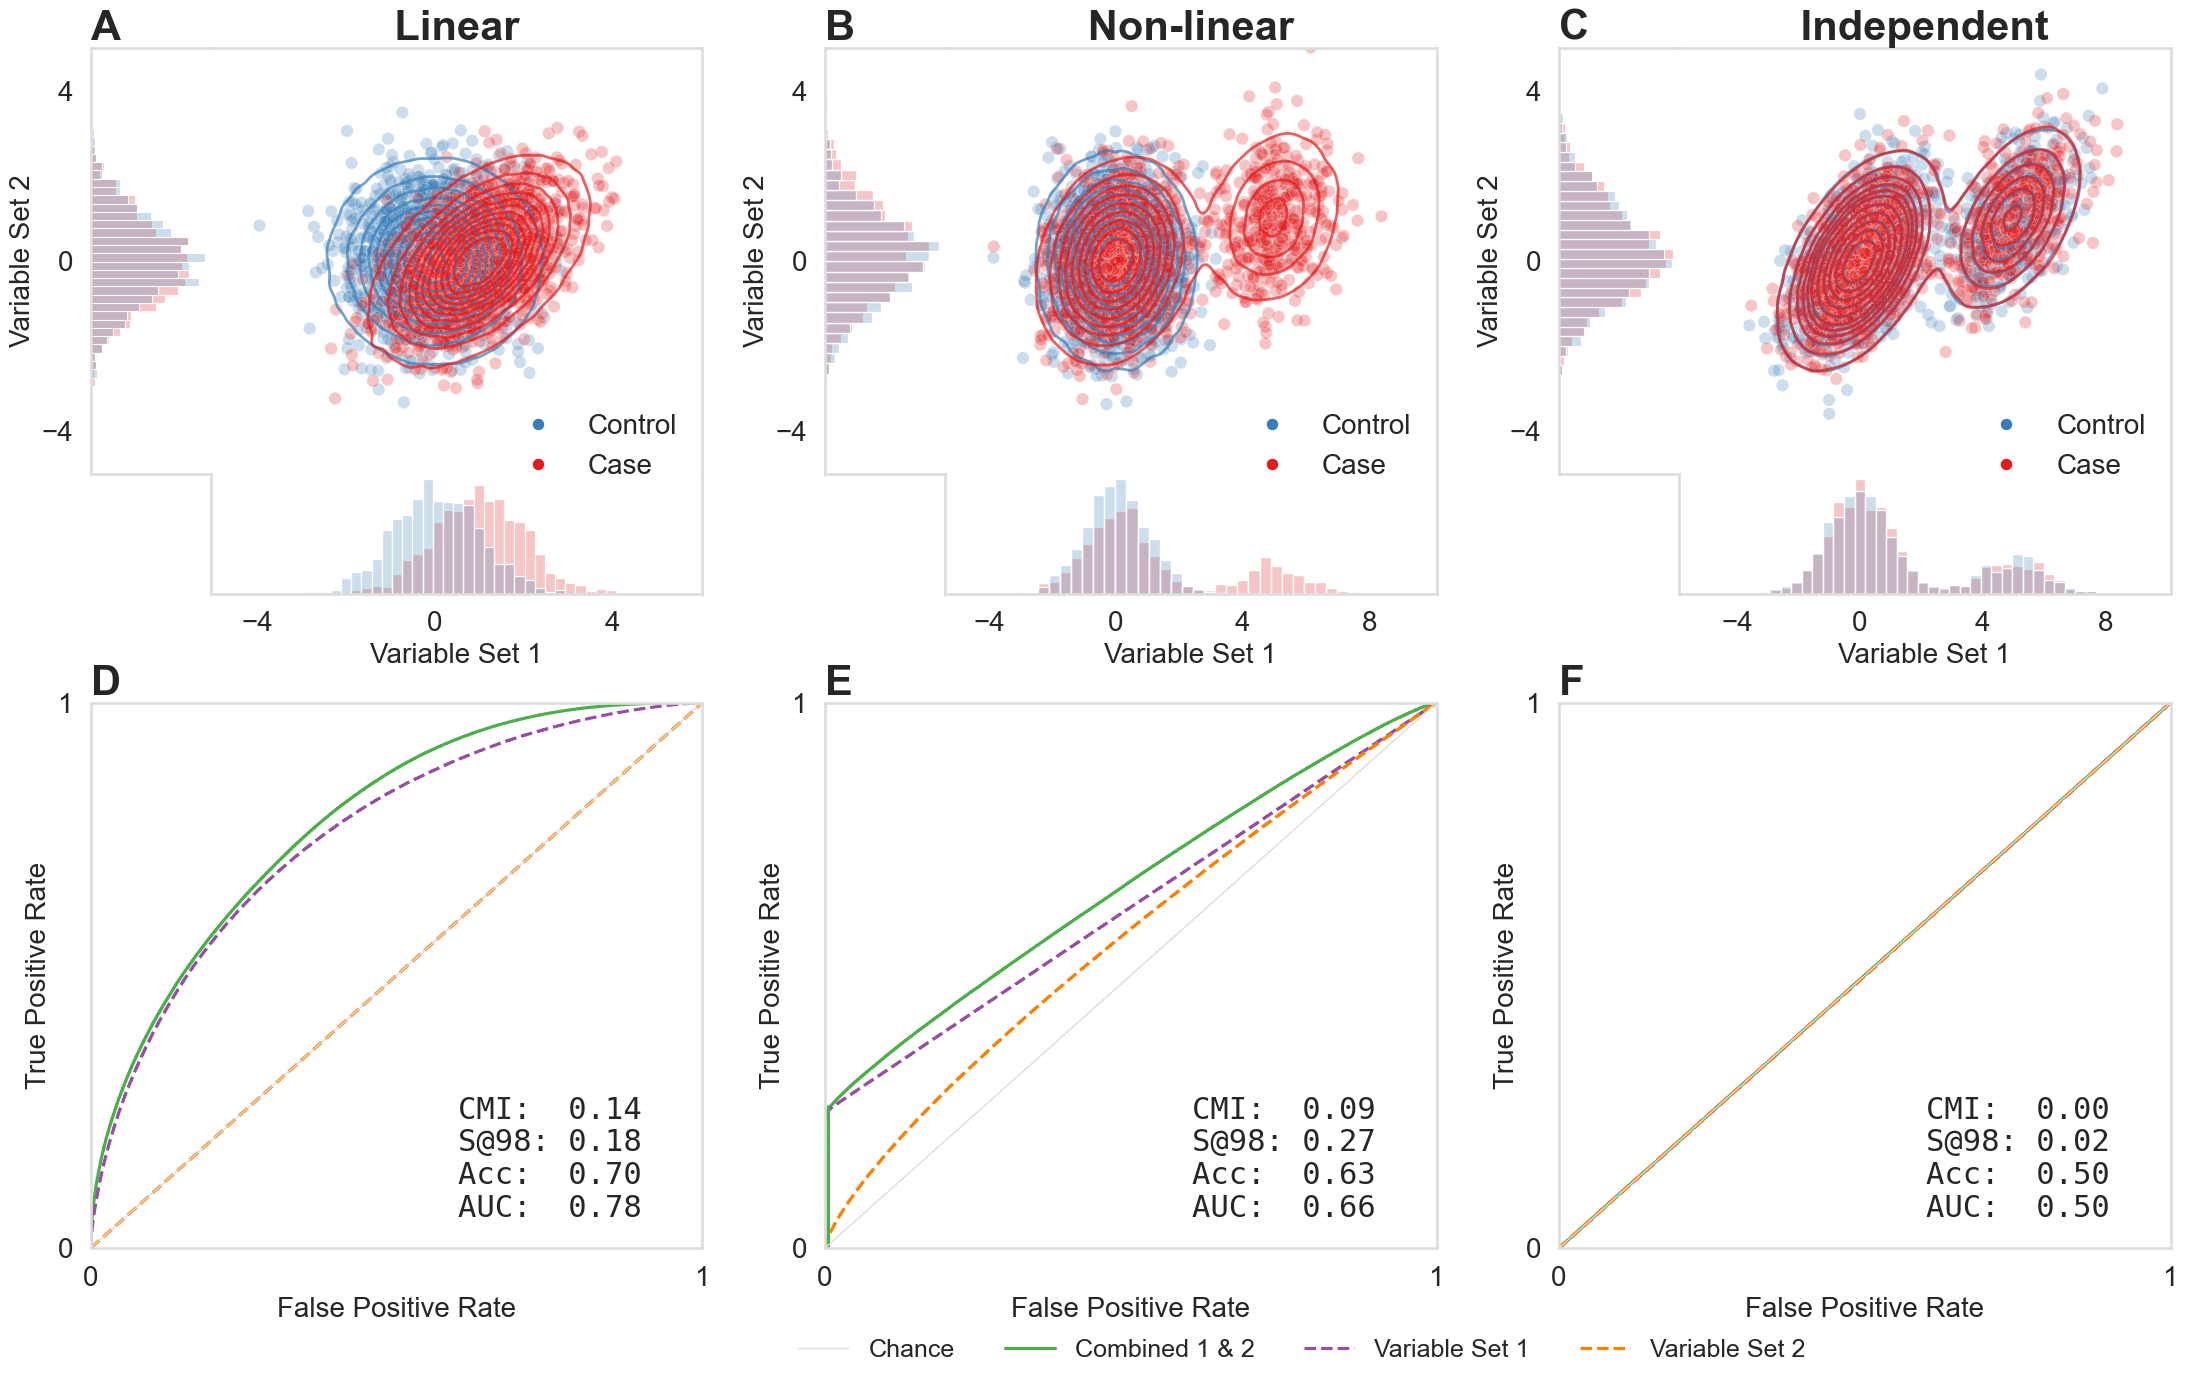

In [120]:
fig, axs = plt.subplots(2, 3, figsize=(26, 15))
gs = gridspec.GridSpec(NROWS, NCOLS, fig)
SIMULATIONS = ["Linear", "Non-linear", "Independent"]
fig_labels = ["A", "B", "C"]
for i in range(NCOLS):
    df = all_data[i][0][::4]
    df_ = df[::skip]
    x_min, x_max = df["view1"].min(), df["view1"].max()
    y_min, y_max = df["view2"].min(), df["view2"].max()
    x, y = df["view1"], df["view2"]

    fig.subplots_adjust(0.1, 0.1, 0.9, 0.9)
    ax = axs[0][i]
    # for idx, label in enumerate(df["label"].unique()):
    #     color = PALETTE[idx]
    #     x = df[df["label"] == label]["view1"]
    #     y = df[df["label"] == label]["view2"]

    sns.scatterplot(
        x="view1",
        y="view2",
        data=df_,
        hue="label",
        # color=PALETTE[0],
        palette=PALETTE[:2],
        alpha=0.25,
        ax=ax,
    )
    ax.get_legend().remove()
    sns.kdeplot(
        data=df,
        x="view1",
        y="view2",
        hue=df["y"],
        fill=False,
        alpha=0.7,
        levels=levels,
        linewidths=2.0,
        # color=PALETTE[0],
        palette=PALETTE[:2],
        ax=ax,
    )
    divider = make_axes_locatable(ax)

    axHistx = divider.append_axes("bottom", 1.2, pad=0.0, sharex=ax)
    axHisty = divider.append_axes("left", 1.2, pad=0.0, sharey=ax)
    # Hide grid lines
    # axHistx.axis(False)
    # axHisty.axis(False)

    # plot marginal histograms
    sns.histplot(
        data=df_,
        x="view1",
        bins=bins,
        hue=df_["y"],
        # color=PALETTE[0],
        palette=PALETTE[:2],
        alpha=0.25,
        kde=density,
        ax=axHistx,
        legend=False,
    )
    # g1.plot_marginals(sns.histplot, data=df, kde=True, bins=bins
    sns.histplot(
        data=df_,
        y="view2",
        bins=bins,
        hue=df_["y"],
        # color=PALETTE[0],
        palette=PALETTE[:2],
        alpha=0.25,
        kde=density,
        ax=axHisty,
        legend=False,
    )

    axHistx.set_xlabel("Variable Set 1", fontsize=axislabelfontsize)
    axHisty.set_ylabel("Variable Set 2", fontsize=axislabelfontsize)

    # Set tick labels for jjoint plot
    ax.label_outer(remove_inner_ticks=True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    axHistx.spines["top"].set_visible(False)
    axHisty.spines["right"].set_visible(False)
    axHistx.set_ylabel(None)
    axHisty.set_xlabel(None)
    if i == 0:
        axHistx.set_xticks([-4, 0, 4])
        axHisty.set_yticks([-4, 0, 4])
    else:
        axHistx.set_xticks([-4, 0, 4, 8])
        axHisty.set_yticks([-4, 0, 4])
    ax.set_ylim([-5, 5])
    axHistx.tick_params(axis="x", which="major", labelsize=axislabelfontsize)
    axHisty.tick_params(axis="y", which="major", labelsize=axislabelfontsize)
    axHisty.set(xlabel=None, xticklabels=[])
    axHistx.set(ylabel=None, yticklabels=[])

    # ax.legend(None)
    ax.title.set_text(" " * spacings[i] + SIMULATIONS[i] + " " * spacings[i])
    ax.title.set_fontweight("bold")
    ax.title.set_horizontalalignment("center")
    ax.title.set_fontsize(titlefontsize + 10)

    # label with ABC
    axHisty.set_title(fig_labels[i], loc="left", weight="bold", fontsize=fontsize + 10)

    # change the legend
    # if i == 2:
    leg = ax.legend(
        fontsize=fontsize,
        frameon=False,
        loc="upper right",
        bbox_to_anchor=(1, 0.2),
    )
    # change the legend title and labels
    leg.set_title("")
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    # ax.get_legend().set_alpha(0.1)

# plot the second part
ROW += 1
# ax = plt.subplots(nrows=1, ncols=3, figsize=(26,8), gridspec_kw={'width_ratios': [.8, .8, .8]})
fig_labels = ["D", "E", "F"]
for i in range(NCOLS):
    df_roc, df_roc_v1, df_roc_v2 = all_data[i][3:6]
    ax = axs[1][i]
    # ax.set_aspect('equal')
    # ax.set_aspect(0.95)
    # sns.lineplot(data=df_roc_all, x="fpr", y="tpr", hue="view", ax=ax)
    # ax.set_title(SIMULATIONS[i], fontsize=titlefontsize)
    ax.plot(
        df_roc["fpr"],
        df_roc["tpr"],
        color=PALETTE[2],
        label="Combined 1 & 2",
        linestyle="-",
    )
    ax.plot(
        df_roc_v1["fpr"],
        df_roc_v1["tpr"],
        color=PALETTE[3],
        label="Variable Set 1",
        linestyle="--",
    )
    ax.plot(
        df_roc_v2["fpr"],
        df_roc_v2["tpr"],
        color=PALETTE[4],
        linestyle="--",
        label="Variable Set 2",
    )
    if i == 1:
        # get the s98 values
        s98 = all_data[i][6].loc["joint", "s98"]
        ax.vlines(x=0.005, ymin=0, ymax=s98 - 0.01, color=PALETTE[2], linestyle="-")
    ax.plot([0, 1], [0, 1], color="#dddddd", lw=1, linestyle="-", label="Chance")
    ax.set_xlabel("False Positive Rate", fontsize=axislabelfontsize)
    ax.set_ylabel("True Positive Rate", fontsize=axislabelfontsize)
    ax.set_title(fig_labels[i], loc="left", weight="bold", fontsize=fontsize + 10)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_ylim(top=1)
    ax.set_xlim(right=1)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.tick_params(axis="both", which="major", labelsize=axislabelfontsize)
    ax.set_axisbelow(True)
    ax.spines["left"].set_color("#dddddd")
    ax.spines["right"].set_color("#dddddd")
    ax.spines["top"].set_color("#dddddd")
    ax.spines["bottom"].set_color("#dddddd")
    if i == 1:
        ax.legend(fontsize=fontsize, frameon=False)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(
            handles,
            labels,
            fontsize=fontsize - 2,
            frameon=False,
            loc="lower left",
            ncol=4,
            bbox_to_anchor=(-0.08, -0.25),
        )

    # plt.subplots_adjust(wspace=1)

    # annotate the stats on the plot
    stats = all_data[i][6]
    # print(stats)
    MI = stats.loc["joint", "MI"]
    CMI = stats.loc["view1", "CMI"]
    s98 = stats.loc["joint", "s98"]
    AUC = stats.loc["joint", "AUC"]
    Acc = stats.loc["joint", "ACC"]
    x_pos = 0.6
    y_pos = 0.1
    k = 0.06

    ljust = 5
    for j, txt in enumerate(
        [
            f"{'AUC:'.ljust(ljust)} {AUC:.2f}",
            f"{'Acc:'.ljust(ljust)} {Acc:.2f}",
            f"{'S@98:'.ljust(ljust)} {s98:.2f}",
            f"{'CMI:'.ljust(ljust)} {CMI:.2f}",
        ]
    ):
        # Set the font properties
        # font_props = {'family': 'monospace'}

        # # Add text to the figure
        # for i, (text, number) in enumerate(text_data):
        #     plt.text(0, 1 - i * 0.2, f"{text.ljust(10)} {number}", **font_props, verticalalignment='top')

        ax.text(
            x_pos,
            y_pos + k * j,
            txt,
            transform=ax.transAxes,
            fontsize=fontsize + 2,
            verticalalignment="top",
            horizontalalignment="left",
            family="monospace",
        )
fig_name = "figure-s4"
from pathlib import Path

FIG_PATH = Path("/Volumes/Extreme Pro/cancer/output/figures/")
FIG_PATH.mkdir(parents=True, exist_ok=True)
plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")
plt.show()

In [112]:
from pathlib import Path

FIG_PATH = Path("/Volumes/Extreme Pro/cancer/output/figures/")
FIG_PATH.mkdir(parents=True, exist_ok=True)
plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>